# Table Length Measurements

Python program for analysing measurements of the length of the lecture table in Auditorium A at NBI.  
There are two measurements each with estimated error of the table length:
1. Measurement with a 30cm ruler.
2. Measurement with a 2m folding ruler.

Each person was asked not only to state the measurement, but also their (gu)estimated uncertainty. None of the persons could see others measurements in order to get the largest degree of independence. Also, the 30cm ruler measurement was asked to be done first. Finally, those measuring were asked to try to measure to the mm, even if precision was less than this, and not to correct any measurement once written down.

Please submit your estimates to the [Table Measurement Result Submission Page](https://docs.google.com/forms/d/1QdxmkUjxxdkDyAZh92QHLgvEb_HsX8fav3915ypBxx0/edit).

### Authors: 
- Troels C. Petersen (Niels Bohr Institute)

### Date:    
- 21-11-2025 (latest update)

***

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit, cost
from scipy import stats
from scipy.special import erfc                         # Error function, to get integral of Gaussian
import scienceplots
plt.style.use(['science','notebook','grid'])

Options for the program: 

In [61]:
blinded =   False            # Add a random (but fixed) offset to the 30cm and 2m data seperately
save_plots = False

r = np.random             # Random generator
r.seed(42)                # Set a random seed (but a fixed one)

## Initial data analysis:

Before we even look at the look at the data, we decide whether or not we want to blind the analysis by adding a constant to all measurements. This is a good way of working, as we then don't get affected by prior beliefs. Note that a different blinding constant is added for the 30cm ruler and 2m folding rule measurements, so that only after unblinding can the correspondence between the two be considered as a vital cross check.

In [62]:
if blinded:
    blinding30cm = r.normal(0, 0.1)      # I add a constant (Gaussian with +-10cm) to remain "blind"
    blinding2m   = r.normal(0, 0.1)      # I add a constant (Gaussian with +-10cm) to remain "blind"
else:
    blinding30cm = 0
    blinding2m = 0

Define what datafiles we want to look at. Extend it to suit your analysis: 

In [63]:
infiles = ["data_TableMeasurements2025.txt",
           "data_TableMeasurements2024.txt",
           "data_TableMeasurements2023.txt",
           "data_TableMeasurements2022.txt",
           "data_TableMeasurements2021.txt",
           "data_TableMeasurements2020.txt",
           "data_TableMeasurements2019.txt",
           "data_TableMeasurements2018.txt",
           "data_TableMeasurements2017.txt",
           "data_TableMeasurements2016.txt",
           "data_TableMeasurements2015.txt",
           "data_TableMeasurements2014.txt",
           "data_TableMeasurements2013.txt",
           "data_TableMeasurements2012.txt",
           "data_TableMeasurements2011.txt",
           "data_TableMeasurements2010.txt",
           "data_TableMeasurements2009.txt"]

We read in all the data from the `infiles` files (and print the values as a cross check):

In [64]:
L30cm = np.array([])
eL30cm = np.array([])
L2m = np.array([])
eL2m = np.array([])

# Loop over files and open them
for infile in infiles:
    
    tmp_L30cm, tmp_eL30cm, tmp_L2m, tmp_eL2m = np.loadtxt(infile, skiprows=2, unpack=True)
    
    # Note that blinding is applied before storing the values read:
    L30cm = np.append(L30cm, tmp_L30cm + blinding30cm)
    eL30cm = np.append(eL30cm, tmp_eL30cm)
    L2m = np.append(L2m, tmp_L2m + blinding2m)
    eL2m = np.append(eL2m, tmp_eL2m)
    
N_read  = len(L30cm)       # Number of measurements read in total
print(L30cm)
print(f"\n\nRead all {len(infiles)} file(s) which included {N_read} measurements. \n")

[3.777  3.355  3.383  3.342  3.081  3.365  3.364  3.6    3.359  3.368
 3.357  3.373  3.3    3.355  1.221  3.352  3.357  3.661  3.342  3.362
 2.708  3.348  3.375  3.36   3.408  3.374  3.662  3.366  3.468  3.359
 3.305  3.305  3.288  3.369  3.361  3.346  3.357  3.664  3.365  2.654
 3.356  3.37   3.063  3.363  3.354  3.363  3.378  3.355  3.371  3.7
 3.376  3.335  3.365  3.647  3.347  3.341  3.397  3.362  3.357  3.38
 3.273  3.24   3.335  3.37   2.765  3.2    3.345  3.362  3.37   3.353
 3.362  3.29   3.655  3.25   3.364  3.054  3.358  3.365  2.372  3.703
 3.56   3.345  3.385  3.375  3.364  3.31   3.364  3.352  3.363  3.349
 3.035  3.375  3.361  3.065  3.365  3.348  3.366  3.368  3.369  3.362
 3.36   3.364  3.352  3.364  3.635  3.367  3.545  3.651  3.231  3.55
 1.355  3.306  3.364  3.362  3.362  3.039  3.062  3.371  3.351  3.671
 3.368  3.37   3.365  3.364  3.371  3.367  3.355  3.359  3.357  3.363
 3.355  3.387  3.362  3.371  3.355  3.374  3.374  3.396  3.693  3.352
 3.373  3.358  3.36   3.

### First thing: Plot the data!

It is paramount that one plots data - it is the only way to get a good sense of it.

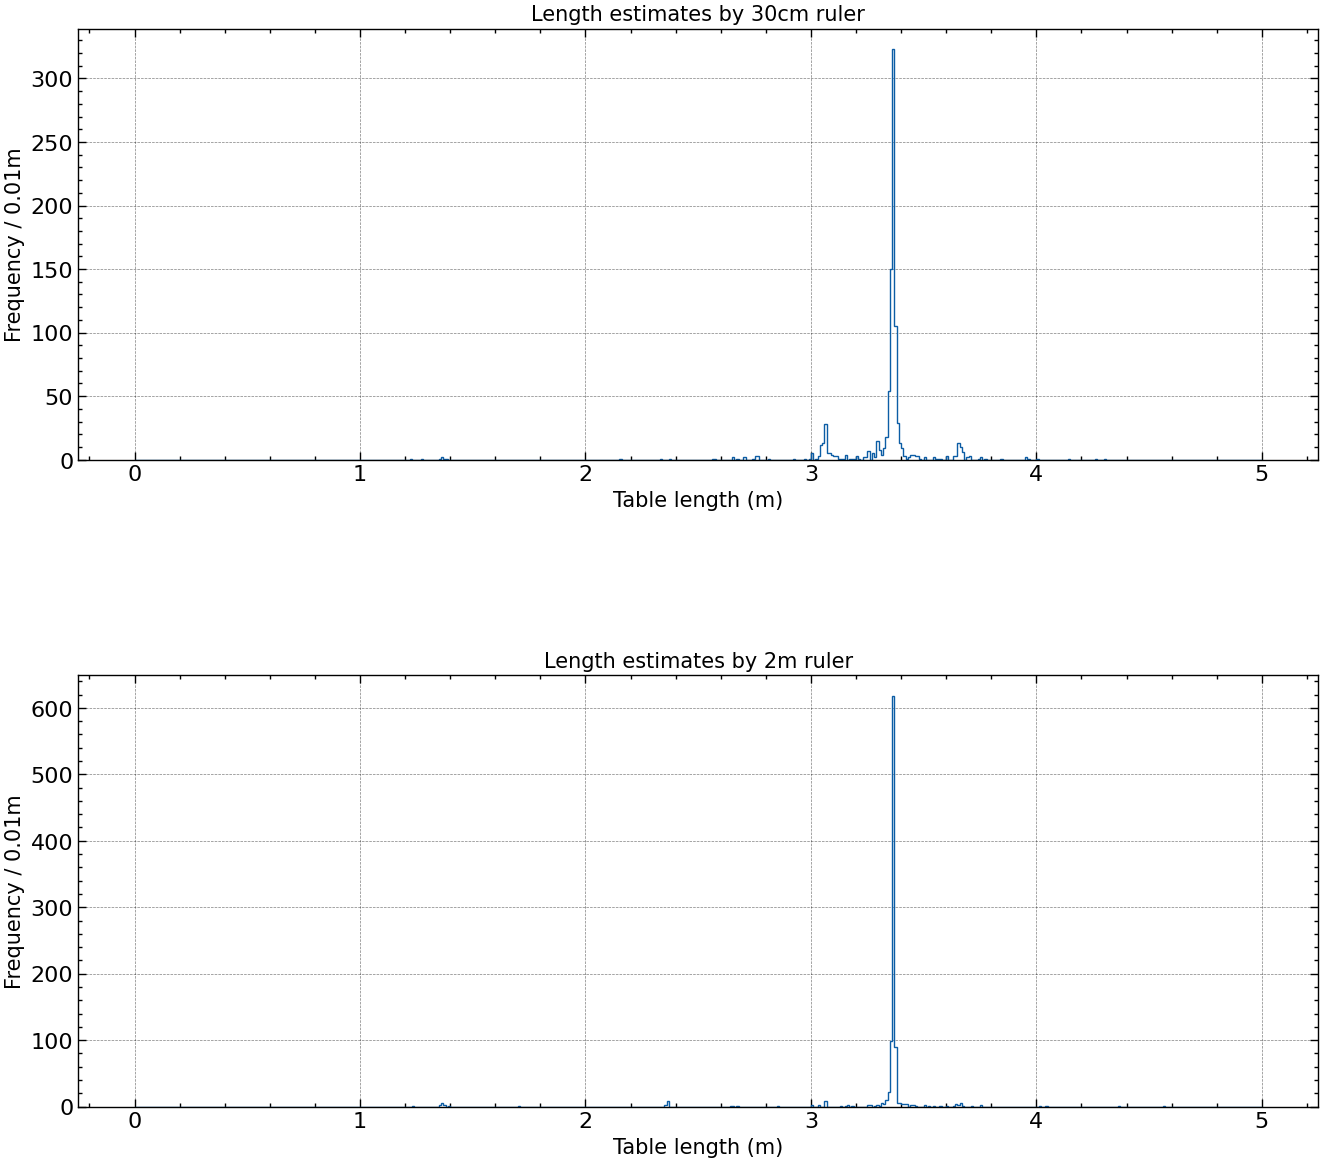

In [65]:
# Carefully consider binning - this might have to be changed, and subplots/inserts are defintely worth considering!
Nbins = 500
minL = 0.0
maxL = 5.0
binwidth = (maxL-minL)/Nbins

# Define two histograms with all the lengths recorded:
fig_raw, ax = plt.subplots(nrows=2, figsize=(16,14), gridspec_kw={'hspace':0.5})
ax_L30cm, ax_L2m = ax

hist_L30cm = ax_L30cm.hist(L30cm, bins=Nbins, range=(minL, maxL), histtype='step', label='30cm data')
ax_L30cm.set_title('Length estimates by 30cm ruler',fontsize=15)
ax_L30cm.set_ylabel('Frequency / 0.01m',fontsize=15)
ax_L30cm.set_xlabel('Table length (m)',fontsize=15)

hist_L2m = ax_L2m.hist(L2m, bins=Nbins, range=(minL, maxL), histtype='step', label='2m data')
ax_L2m.set_title('Length estimates by 2m ruler',fontsize=15)
ax_L2m.set_ylabel('Frequency / 0.01m',fontsize=15)
ax_L2m.set_xlabel('Table length (m)',fontsize=15)

fig_raw.tight_layout;

## 30 cm ruler:

We consider the measurements for the 30cm ruler and focus on that for now. Below is a mean and standard deviation (Std) calculation along with a general Gaussian fit to all the data. Somehow, the Std doesn't seem optimal/right...  

In [66]:
print(f"  Initial estimate of raw data (30 cm ruler):  {L30cm.mean():.3f} +- {L30cm.std(ddof=1)/np.sqrt(len(L30cm)):.3f} m     (Std = {L30cm.std(ddof=1):.3f})")

  Initial estimate of raw data (30 cm ruler):  3.324 +- 0.008 m     (Std = 0.239)


### Next steps:

From the above, you should by now be aware, that there is definitely room for improvement, due to some poor measurement. You want to exclude (or correct?) these, but remember, you should be able to argue for each and every point you remove or correct.

In fact, make sure that PRINT OUT EVERY MEASUREMENT THAT YOU EXCLUDE, along with numbers arguing their case! Barlow 4.2.3 (and the note above this very short section) along with Chauvenet's Criterion might serve as guidelines.

It is now up to you to select in (based on solid **quantified** arguments) the data, and subsequently produce a better estimate of the length of the table in world famous Auditorium A. Good luck...

In [67]:
def chauvenet(y, mean=None, stdv=None):
   #-----------------------------------------------------------
   # Input:  NumPy arrays x, y that represent measured data
   #         A single value of a mean can be entered or a 
   #         sequence of means with the same length as 
   #         the arrays x and y. In the latter case, the 
   #         mean could be a model with best-fit parameters.
   # Output: It returns a boolean array as filter.
   #         The False values correspond to the array elements
   #         that should be excluded
   # 
   # First standardize the distances to the mean value
   # d = abs(y-mean)/stdv so that this distance is in terms
   # of the standard deviation.  
   # Then the  CDF of the normal distr. is given by 
   # phi = 1/2+1/2*erf(d/sqrt(2))
   # Note that we want the CDF from -inf to -d and from d to +inf.
   # Note also erf(-d) = -erf(d).
   # Then the threshold probability = 1-erf(d/sqrt(2))
   # Note, the complementary error function erfc(d) = 1-erf(d)
   # So the threshold probability pt = erfc(d/sqrt(2))
   # If d becomes bigger, this probability becomes smaller.
   # If this probability (to obtain a deviation from the mean)
   # becomes smaller than 1/(2N) than we reject the data point
   # as valid. In this function we return an array with booleans 
   # to set the accepted values.
   # 
   # use of filter:
   # xf = x[filter]; yf = y[filter]
   # xr = x[~filter]; yr = y[~filter]
   # xf, yf are cleaned versions of x and y and with the valid entries
   # xr, yr are the rejected values from array x and y
   #-----------------------------------------------------------
   if mean is None:
      mean = y.mean()           # Mean of incoming array y
   if stdv is None:
      stdv = y.std()            # Its standard deviation
   N = len(y)                   # Lenght of incoming arrays
   criterion = 1.0/(2*N)        # Chauvenet's criterion
   d = abs(y-mean)/stdv         # Distance of a value to mean in stdv's
   d /= 2.0**0.5                # The left and right tail threshold values
   prob = erfc(d)               # Area normal dist.    
   filter = prob >= criterion   # The 'accept' filter array with booleans
   return filter                # Use boolean array outside this function

In [68]:
# Sort the data (perhaps good before printing?) and then exclude those you find dubious (I will use Chauvenet's Criterion):
L30cm_sorted = np.sort(L30cm)

#Using Chauvenet's Criterion
for i in range(4):
    filter  = chauvenet(y = L30cm_sorted, mean = np.mean(L30cm_sorted), stdv = np.std(L30cm_sorted))
    L30cm_subset_sorted = L30cm_sorted[filter]
    print(f"  The number of measurements used before and after is: {len(L30cm_sorted):d} and {len(L30cm_subset_sorted):d}")
    L30cm_sorted = L30cm_subset_sorted

L30cm_mean_sorted = np.mean(L30cm_sorted)
L30cm_std_sorted = np.std(L30cm_sorted, ddof = 1)
L30cm_err_sorted = L30cm_std_sorted/np.sqrt(len(L30cm_sorted))

print(f"Mean: {L30cm_mean_sorted:.3f}")
print(f'STD: {L30cm_std_sorted:.3f}')
print(f'Mu: {L30cm_err_sorted:.3f}')

print(f"Estimate of non-raw data (30 cm ruler) (unweighted):  {L30cm_sorted.mean():.3f} +- {L30cm_err_sorted:.3f} m     (Std = {L30cm_std_sorted:.3f})")

  The number of measurements used before and after is: 962 and 950
  The number of measurements used before and after is: 950 and 931
  The number of measurements used before and after is: 931 and 927
  The number of measurements used before and after is: 927 and 926
Mean: 3.346
STD: 0.118
Mu: 0.004
Estimate of non-raw data (30 cm ruler) (unweighted):  3.346 +- 0.004 m     (Std = 0.118)


In [69]:
# ---------- Correct Weighted Mean Function ----------
def weighted_mean(values, errors):
    weights = 1.0 / (errors**2)
    weighted_mean = np.sum(weights * values) / np.sum(weights)
    weighted_err  = np.sqrt(1.0 / np.sum(weights))   # correct error on weighted mean
    return weighted_mean, weighted_err


# ---------- Chauvenet Filter ----------
def chauvenet_filter(values, errors, iterations=4):
    v = values.copy()
    e = errors.copy()

    for i in range(iterations):
        mean_ = np.mean(v)
        std_  = np.std(v)

        mask = chauvenet(y=v, mean=mean_, stdv=std_)   # boolean mask

        before = len(v)
        v = v[mask]          # apply to values
        e = e[mask]          # apply to errors (same mask!)
        after = len(v)

        print(f"Iteration {i+1}: kept {after} of {before} values")

    return v, e


# ---------- ALIGN LENGTHS BEFORE FILTERING ----------
# Ensures L30cm and eL30cm have matching lengths
N = min(len(L30cm), len(eL30cm))
L30cm = L30cm[:N]
eL30cm = eL30cm[:N]

print(f"Initial aligned lengths: {len(L30cm)} measurements, {len(eL30cm)} errors\n")


# ---------- RUN FILTERING ----------
L30cm_filtered, eL30cm_filtered = chauvenet_filter(L30cm, eL30cm, iterations=4)


# ---------- COMPUTE WEIGHTED RESULT ----------
mean, err = weighted_mean(L30cm_filtered, eL30cm_filtered)


# ---------- PRINT FINAL RESULT ----------
print("\nFinal Weighted Result (30 cm ruler):")
print(f"  {mean:.4f} ± {err:.4f} m")


Initial aligned lengths: 962 measurements, 962 errors

Iteration 1: kept 950 of 962 values
Iteration 2: kept 931 of 950 values
Iteration 3: kept 927 of 931 values
Iteration 4: kept 926 of 927 values

Final Weighted Result (30 cm ruler):
  3.3619 ± 0.0002 m


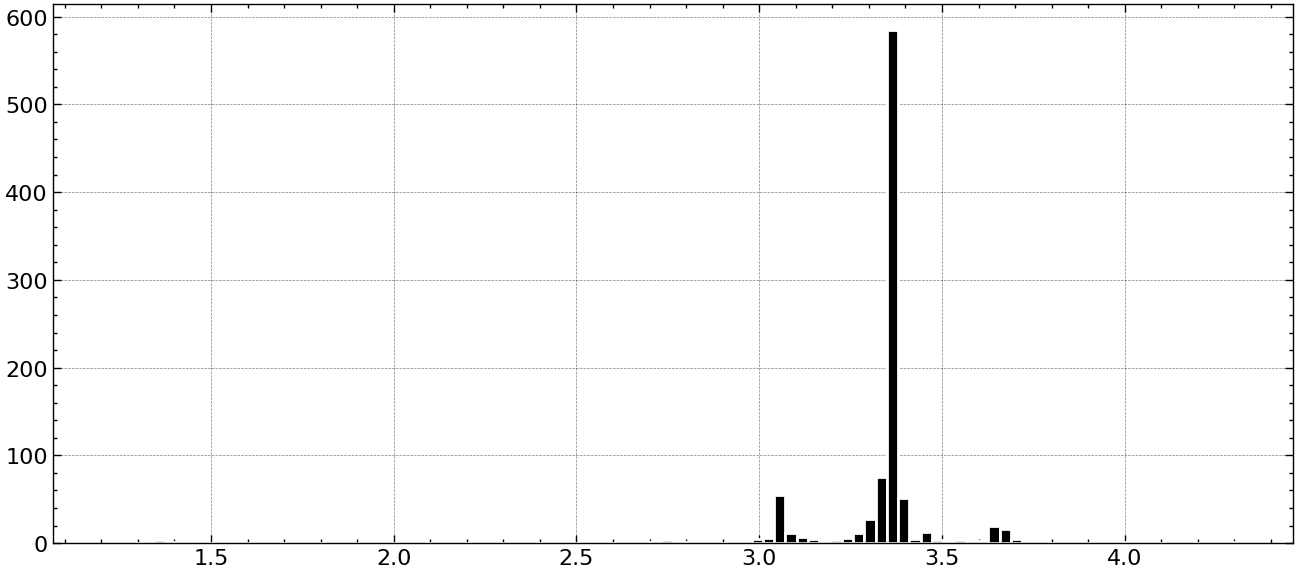

In [70]:
#d_totals = np.diff(np.unique(totals)).min()
#left_of_first_bin_totals = totals.min() - d_totals/2
#right_of_first_bin_totals = totals.max() + d_totals/2
N_bins = 100
fig, ax = plt.subplots(figsize=(16, 7)) 
hist = ax.hist(L30cm, bins=N_bins, range=(L30cm.min(), L30cm.max()), color="black", edgecolor = 'white', linewidth=2, label="Data")

# 2 meter ruler

In [71]:
import numpy as np

# ----------------------------------------------------------
# ----------- UNWEIGHTED: SORTED + CHAUVENET ---------------
# ----------------------------------------------------------

# Sort the data
L2m_sorted = np.sort(L2m)

# Apply Chauvenet's criterion repeatedly
for i in range(4):
    mask = chauvenet(y=L2m_sorted, mean=np.mean(L2m_sorted), stdv=np.std(L2m_sorted))
    L2m_subset_sorted = L2m_sorted[mask]
    print(f"Iteration {i+1}: kept {len(L2m_subset_sorted)} of {len(L2m_sorted)} values")
    L2m_sorted = L2m_subset_sorted

# Compute unweighted stats
L2m_mean_sorted = np.mean(L2m_sorted)
L2m_std_sorted = np.std(L2m_sorted, ddof=1)
L2m_err_sorted = L2m_std_sorted / np.sqrt(len(L2m_sorted))

# Print unweighted results
print("\nUnweighted Result (2 m ruler):")
print(f"Mean: {L2m_mean_sorted:.5f}")
print(f"STD:  {L2m_std_sorted:.5f}")
print(f"Mu:   {L2m_err_sorted:.5f}")
print(f"Estimate (unweighted): {L2m_sorted.mean():.4f} ± {L2m_err_sorted:.4f} m  (Std = {L2m_std_sorted:.4f})")

Iteration 1: kept 945 of 962 values
Iteration 2: kept 928 of 945 values
Iteration 3: kept 895 of 928 values
Iteration 4: kept 876 of 895 values

Unweighted Result (2 m ruler):
Mean: 3.36298
STD:  0.01177
Mu:   0.00040
Estimate (unweighted): 3.3630 ± 0.0004 m  (Std = 0.0118)


In [74]:
# ----------------------------------------------------------
# ----------- WEIGHTED: CORRECT MASKING --------------------
# ----------------------------------------------------------

# Correct weighted mean function
def weighted_mean(values, errors):
    weights = 1.0 / (errors**2)
    weighted_mean = np.sum(weights * values) / np.sum(weights)
    weighted_err  = np.sqrt(1.0 / np.sum(weights))  # correct error of weighted mean
    return weighted_mean, weighted_err


# Chauvenet filter that keeps values + errors aligned
def chauvenet_filter(values, errors, iterations=4):
    v = values.copy()
    e = errors.copy()

    for i in range(iterations):
        mean_ = np.mean(v)
        std_  = np.std(v)

        mask = chauvenet(y=v, mean=mean_, stdv=std_)

        before = len(v)
        v = v[mask]
        e = e[mask]
        after = len(v)

        print(f"Weighted Iteration {i+1}: kept {after} of {before} values")

    return v, e


# ---------- REMOVE ZERO OR NEGATIVE ERRORS ----------
valid_err_mask = eL2m > 0
L2m = L2m[valid_err_mask]
eL2m = eL2m[valid_err_mask]

print(f"Removed {np.sum(~valid_err_mask)} entries with zero/negative errors")
print(f"After cleaning: {len(L2m)} measurements, {len(eL2m)} errors")


# ---------- ALIGN LENGTHS BEFORE FILTERING ----------
N = min(len(L2m), len(eL2m))
L2m = L2m[:N]
eL2m = eL2m[:N]

print(f"\nInitial aligned lengths: {len(L2m)} measurements, {len(eL2m)} errors\n")


# ---------- RUN CHAUVENET FILTERING ----------
L2m_filtered, eL2m_filtered = chauvenet_filter(L2m, eL2m, iterations=4)


# ---------- COMPUTE WEIGHTED RESULT ----------
mean_w, err_w = weighted_mean(L2m_filtered, eL2m_filtered)


# ---------- PRINT FINAL RESULT ----------
print("\nWeighted Result (2 m ruler):")
print(f"  {mean_w:.4f} ± {err_w:.4f} m")


Removed 21 entries with zero/negative errors
After cleaning: 941 measurements, 941 errors

Initial aligned lengths: 941 measurements, 941 errors

Weighted Iteration 1: kept 916 of 941 values
Weighted Iteration 2: kept 884 of 916 values
Weighted Iteration 3: kept 868 of 884 values
Weighted Iteration 4: kept 847 of 868 values

Weighted Result (2 m ruler):
  3.3625 ± 0.0001 m


In [75]:
import numpy as np

# ---------- helper functions (reuse/consistent with earlier code) ----------
def weighted_mean(values, errors):
    """Return (weighted_mean, weighted_error_on_mean). Assumes errors > 0."""
    w = 1.0 / (errors**2)
    wm = np.sum(w * values) / np.sum(w)
    werr = np.sqrt(1.0 / np.sum(w))
    return wm, werr

def chauvenet_filter_values(values, iterations=4):
    """Apply Chauvenet to values only (no errors). Returns filtered values."""
    v = values.copy()
    for i in range(iterations):
        mean_ = np.mean(v)
        std_  = np.std(v)
        mask = chauvenet(y=v, mean=mean_, stdv=std_)
        before = len(v)
        v = v[mask]
        after = len(v)
        # optional: print(f"Value Iter {i+1}: kept {after}/{before}")
    return v

def chauvenet_filter_values_and_errors(values, errors, iterations=4):
    """Apply Chauvenet to values and return filtered (values, errors) aligned."""
    v = values.copy()
    e = errors.copy()
    for i in range(iterations):
        mean_ = np.mean(v)
        std_  = np.std(v)
        mask = chauvenet(y=v, mean=mean_, stdv=std_)
        before = len(v)
        v = v[mask]
        e = e[mask]
        after = len(v)
        # optional: print(f"V+E Iter {i+1}: kept {after}/{before}")
    return v, e

# ---------- MAIN: compute unweighted & weighted comparisons ----------
def compare_in_sigmas(L30cm, eL30cm, L2m, eL2m, iterations=4):
    # -------- Unweighted path (operate on values only) --------
    L30_unw = chauvenet_filter_values(np.sort(L30cm), iterations=iterations)
    L2_unw  = chauvenet_filter_values(np.sort(L2m), iterations=iterations)

    # compute sample statistics (unweighted)
    n30 = len(L30_unw)
    n2  = len(L2_unw)

    if n30 < 2 or n2 < 2:
        raise ValueError("Not enough points after unweighted filtering to compute sample std (need >=2).")

    mean30_unw = np.mean(L30_unw)
    std30_unw  = np.std(L30_unw, ddof=1)
    err30_unw  = std30_unw / np.sqrt(n30)

    mean2_unw  = np.mean(L2_unw)
    std2_unw   = np.std(L2_unw, ddof=1)
    err2_unw   = std2_unw / np.sqrt(n2)

    diff_unw = mean30_unw - mean2_unw
    combined_err_unw = np.sqrt(err30_unw**2 + err2_unw**2)

    if combined_err_unw == 0:
        sigma_unw = np.nan
    else:
        sigma_unw = diff_unw / combined_err_unw

    # -------- Weighted path (use errors, remove non-positive errors first) --------
    # remove non-positive errors
    valid30_mask = eL30cm > 0
    valid2_mask  = eL2m > 0

    if np.sum(~valid30_mask) > 0:
        print(f"Removed {np.sum(~valid30_mask)} entries from L30cm with non-positive errors.")
    if np.sum(~valid2_mask) > 0:
        print(f"Removed {np.sum(~valid2_mask)} entries from L2m with non-positive errors.")

    L30_w = L30cm[valid30_mask]
    e30_w = eL30cm[valid30_mask]
    L2_w  = L2m[valid2_mask]
    e2_w  = eL2m[valid2_mask]

    # align lengths defensively (keeps the first N entries if lengths differ)
    N30 = min(len(L30_w), len(e30_w))
    N2  = min(len(L2_w), len(e2_w))
    L30_w = L30_w[:N30]; e30_w = e30_w[:N30]
    L2_w  = L2_w[:N2];  e2_w  = e2_w[:N2]

    # apply Chauvenet filter to values+errors
    L30_w_f, e30_w_f = chauvenet_filter_values_and_errors(L30_w, e30_w, iterations=iterations)
    L2_w_f,  e2_w_f  = chauvenet_filter_values_and_errors(L2_w,  e2_w,  iterations=iterations)

    # ensure we still have data
    if len(L30_w_f) == 0 or len(L2_w_f) == 0:
        raise ValueError("No data left after weighted Chauvenet filtering for one of the datasets.")

    # compute weighted means and their errors
    mean30_w, err30_w = weighted_mean(L30_w_f, e30_w_f)
    mean2_w,  err2_w  = weighted_mean(L2_w_f,  e2_w_f)

    diff_w = mean30_w - mean2_w
    combined_err_w = np.sqrt(err30_w**2 + err2_w**2)

    if combined_err_w == 0:
        sigma_w = np.nan
    else:
        sigma_w = diff_w / combined_err_w

    # -------- Print summary --------
    print("\n--- Unweighted comparison ---")
    print(f"Mean (30cm, unweighted) = {mean30_unw:.6f}    err = {err30_unw:.6f}    N = {n30}")
    print(f"Mean (2m,   unweighted) = {mean2_unw:.6f}    err = {err2_unw:.6f}    N = {n2}")
    print(f"Difference (30cm - 2m) = {diff_unw:.6e}    combined uncertainty = {combined_err_unw:.6e}")
    print(f"Difference in sigmas (unweighted) = {sigma_unw:.4f}")

    print("\n--- Weighted comparison ---")
    print(f"Mean (30cm, weighted) = {mean30_w:.6f}    err = {err30_w:.6f}    N = {len(L30_w_f)}")
    print(f"Mean (2m,   weighted) = {mean2_w:.6f}    err = {err2_w:.6f}    N = {len(L2_w_f)}")
    print(f"Difference (30cm - 2m) = {diff_w:.6e}    combined uncertainty = {combined_err_w:.6e}")
    print(f"Difference in sigmas (weighted) = {sigma_w:.4f}")

    return {
        "unweighted": {"diff": diff_unw, "combined_err": combined_err_unw, "sigma": sigma_unw},
        "weighted":   {"diff": diff_w,   "combined_err": combined_err_w,   "sigma": sigma_w}
    }

# ---------- Run the comparison ----------
results = compare_in_sigmas(L30cm, eL30cm, L2m, eL2m, iterations=4)


Removed 16 entries from L30cm with non-positive errors.

--- Unweighted comparison ---
Mean (30cm, unweighted) = 3.346028    err = 0.003880    N = 926
Mean (2m,   unweighted) = 3.362927    err = 0.000313    N = 847
Difference (30cm - 2m) = -1.689909e-02    combined uncertainty = 3.892404e-03
Difference in sigmas (unweighted) = -4.3416

--- Weighted comparison ---
Mean (30cm, weighted) = 3.361923    err = 0.000176    N = 911
Mean (2m,   weighted) = 3.362513    err = 0.000090    N = 847
Difference (30cm - 2m) = -5.900268e-04    combined uncertainty = 1.978747e-04
Difference in sigmas (weighted) = -2.9818


***

Start by taking a close look at the data, first by inspecting the numbers in the data file (yeps, print the damn thing, and look over the numbers!), and then by considering the histograms produced by running the notebook. To begin with, only consider the 30cm ruler measurements, and disregard the estimated/guessed uncertainties. You can then expand from there, as guided below by questions.


# Questions:

1. Consider the mean, standard deviation, and uncertainty on the mean. Is the result as you would expect it? And do you think that it is close to the best possible (i.e. most accurate and precise) estimate? NOTE: Make sure that you know the difference between accuracy and precision!!! See "Common definition" in: http://en.wikipedia.org/wiki/Accuracy_and_precision

2. Do any of the measurements looks wrong/bad/suspicious? Do you see any repeated mistakes done for obvious reasons? Would you correct or exclude any of the measurements and how would you justify this? This problem requires that you discuss with your peers, and then each do what you think most justified/best. It somehow boils down to how far away a measurement is from the expectation.
Apply the criterion you find fitting to the list of measurements, and perhaps produce a new list with your accepted and possibly corrected measurements in (to save the original data). How many measurements did you throw away in the end?

3. Fit your accepted length measurements with a Gaussian distribution, possibly in a (small?) range around what you believe is the true value. What would be your strategy for choosing a range? Is the Gaussian distribution justified? Also, do you see any "human" effects? Did any of your class mates (or you?) not read to mm precision and rounded the result?

4. Once you have selected the measurements you want to use, calculate the mean, standard deviation, and uncertainty on the mean. How much did your result improve in precision from the raw data in question 1?

5. Now consider also the uncertainties. Try to calculate the weighted mean. Did you get a good Chi2 probability, when doing so? Or are some measurements and/or uncertainties doubtful?

6. In order to consider measurements in light of their uncertainties, one uses the "Pull" distribution. It is defined as the plot of $z_i = \left(x_i - \overline{x} \right)/\sigma_i$ where $\overline{x}$ is the *sample* mean of $x$, and $x_i$ and $\sigma_i$ are the *single measurements* and their corresponding uncertainties. If the measurements and uncertainties are good, then it should give a unit Gaussian. Is that the case? And thus, were the uncertainty estimates/guesses reasonable? If not, then the pull distribution is often used to remove overly precise measurements (those far out on the tails), and afterwards to scale the errors on the remaining measurements to a reasonable level. Consider the pull distribution, and see if any measurements have suspicious uncertainties. Did the Chi2 probablity improve? And did the result improve further in precision? If not, why could that be?

7. Is the number of mismeasurements 30cm below the actual length more common than those 30cm above? Determine the ratio $r_{miss} = N_{30cm~high} / N_{30cm~low}$ including both its statistical uncertainty, and if possible a systematic uncertainty from defining exactly when a measurement is 30cm off.



#### Now repeat the above for the 2m folding rule
...and consider all the questions below as optional problems, where you might just try to solve selected problems.
 
***

8. How much better/worse is the single measurement uncertainty from the 30cm ruler case to the 2m folding rule?

9. Does the length of the table seems to be different when measured with a 30cm and a 2m ruler? Quantify this statement! I.e. what is the difference, and what is the uncertainty on that difference? Is this significantly away from 0?

10. If you were asked for the best estimate of the length of the table, what would you do? (If posssible, read Bevington page 58 bottom!)


### Advanced questions:

11. Is there any correlation between the errors on the measurements and the distance value? I.e. do you see any effect of those measuring e.g. too long having a smaller/larger uncertainty? What would the effect of this be?

# Learning points:

This is a "open" and potentially long exercise, which in essense is meant to illustrate how challeging real data can be, even if it is conceptually simple and in one dimension.

The first learning point is that real data is potentially very complicated, and requires consideration/processing before being as clear cut, as what we simulate. Two approaches could be:
1. A crude/fast *"cut the non-standard (wrong?) measurements away"* analysis, potentially missing something.
2. A detailed *"plot a lot and consider every single point"*, potentially (over-?)using a lot of time.

From this exercise, you should have learned:
1. Always **start by plotting the data**, and ask yourself, if the distributions make sense.
2. In order to remove potential mis-measurements, one uses **Chauvenet's Criterion** and rejects points with a low probability of being correct.
3. Alternatively, one corrects data points (calibration) based on **understanding the reason(s) for these shifts**. 
4. Once the data has been cleaned (distributions Gaussian?), one can apply the usual calculations of mean $\mu$, Standard Deviation $\sigma$, and uncertainty on the mean $\sigma_{\mu}$.
5. When considering **data with uncertainties, the data cleaning is different**, as one considers how far away potential mis-measurements are in units of their uncertainty.
6. **It is always important to have ways of cross checking one's results**, in this case comparing the 30cm ruler with the 2m folding rule result.
7. An alternative method of estimating the length is by fitting the entire distribution with a combination of PDFs (Gaussians). In this way, one avoids excluding data, but rather model the mistakes made.